In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os

In [2]:
# Correct way to install a package in a notebook is to use !, not bare pip
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
df = heart_disease.data
X = heart_disease.data.features
y = heart_disease.data.targets
z = heart_disease.dataids

# data
print(heart_disease.data)


{'ids': None, 'features':      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3

DATA PREPROCESSING AND EDA

In [4]:
categorical_cols = [
    'sex', 'cp', 'fbs', 'restecg',
    'exang', 'slope', 'thal'
]
numerical_cols = [
    'age', 'trestbps', 'chol',
    'thalach', 'oldpeak', 'ca'
]

Handle Missing Values
(Replace categorical values with the most frequent one and numerical values with their medians)

In [5]:
from sklearn.impute import SimpleImputer

num_cleaner = SimpleImputer(strategy='median')
cat_cleaner = SimpleImputer(strategy='most_frequent')


In [6]:
from sklearn.compose import ColumnTransformer

cleaner = ColumnTransformer(   transformers=[
        ('num_clean', num_cleaner, numerical_cols),
        ('cat_clean', cat_cleaner, categorical_cols)
    ],
    remainder='drop'
)


Apply Cleaning

In [7]:
X_clean = cleaner.fit_transform(X)

Histogram for Numerical Features

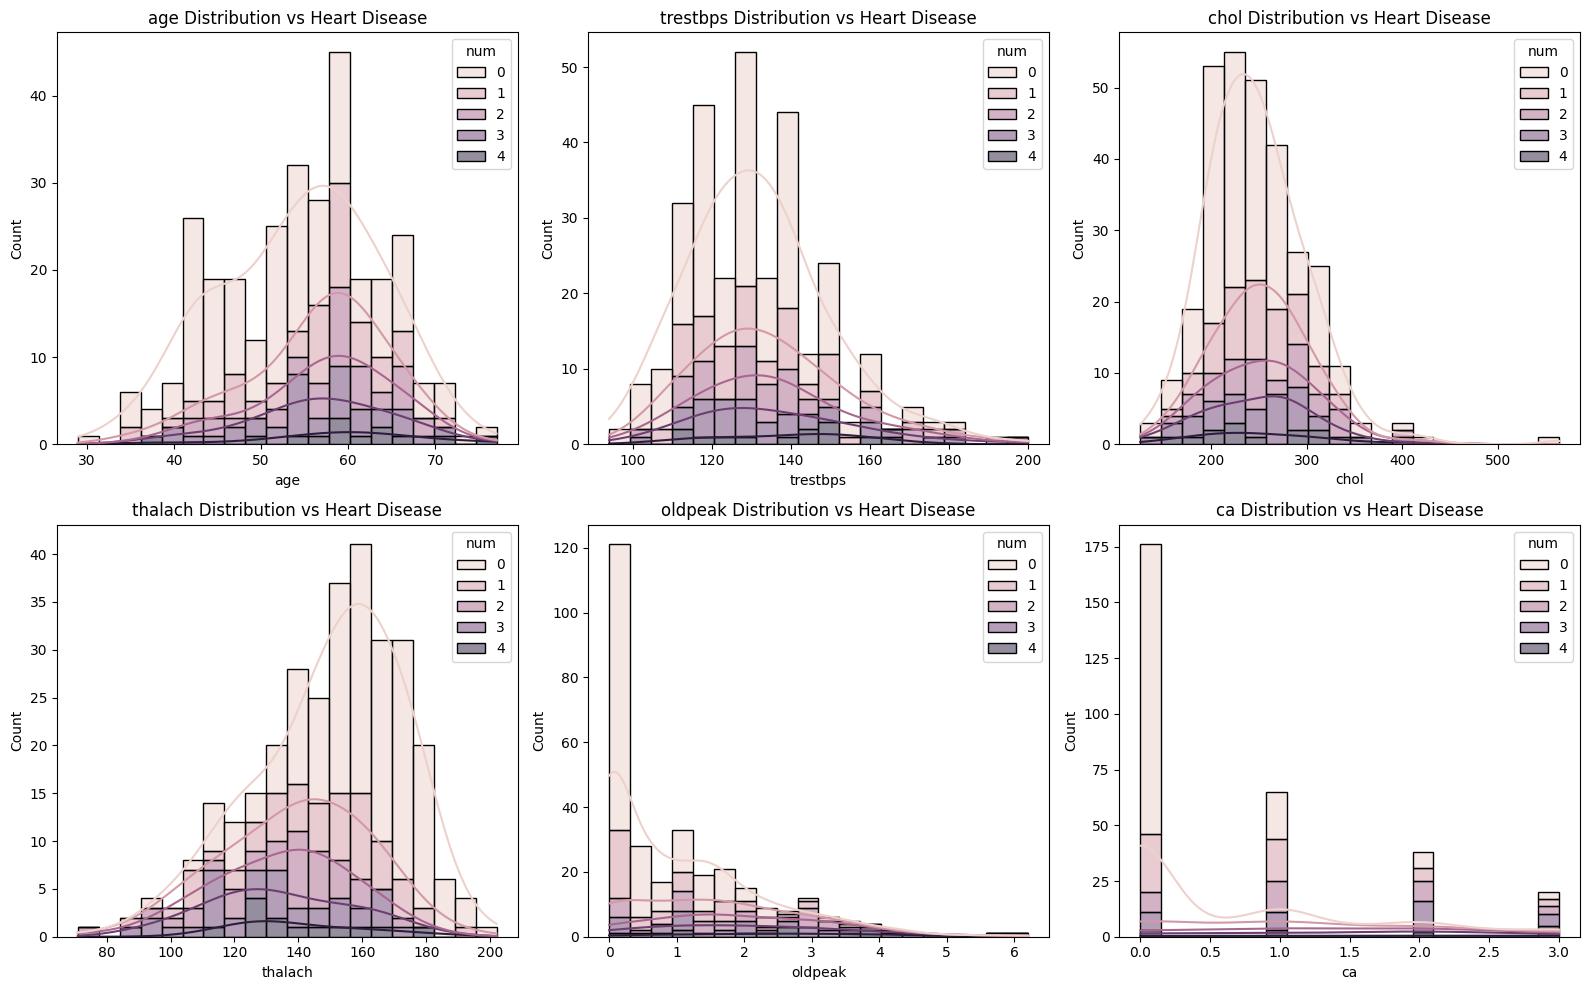

In [8]:
plt.figure(figsize=(16,10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(
        data=heart_disease.data.original,
        x=col,
        hue='num',
        bins=20,
        kde=True,
        multiple='stack'
    )
    plt.title(f'{col} Distribution vs Heart Disease')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Histogram for Categorical Features

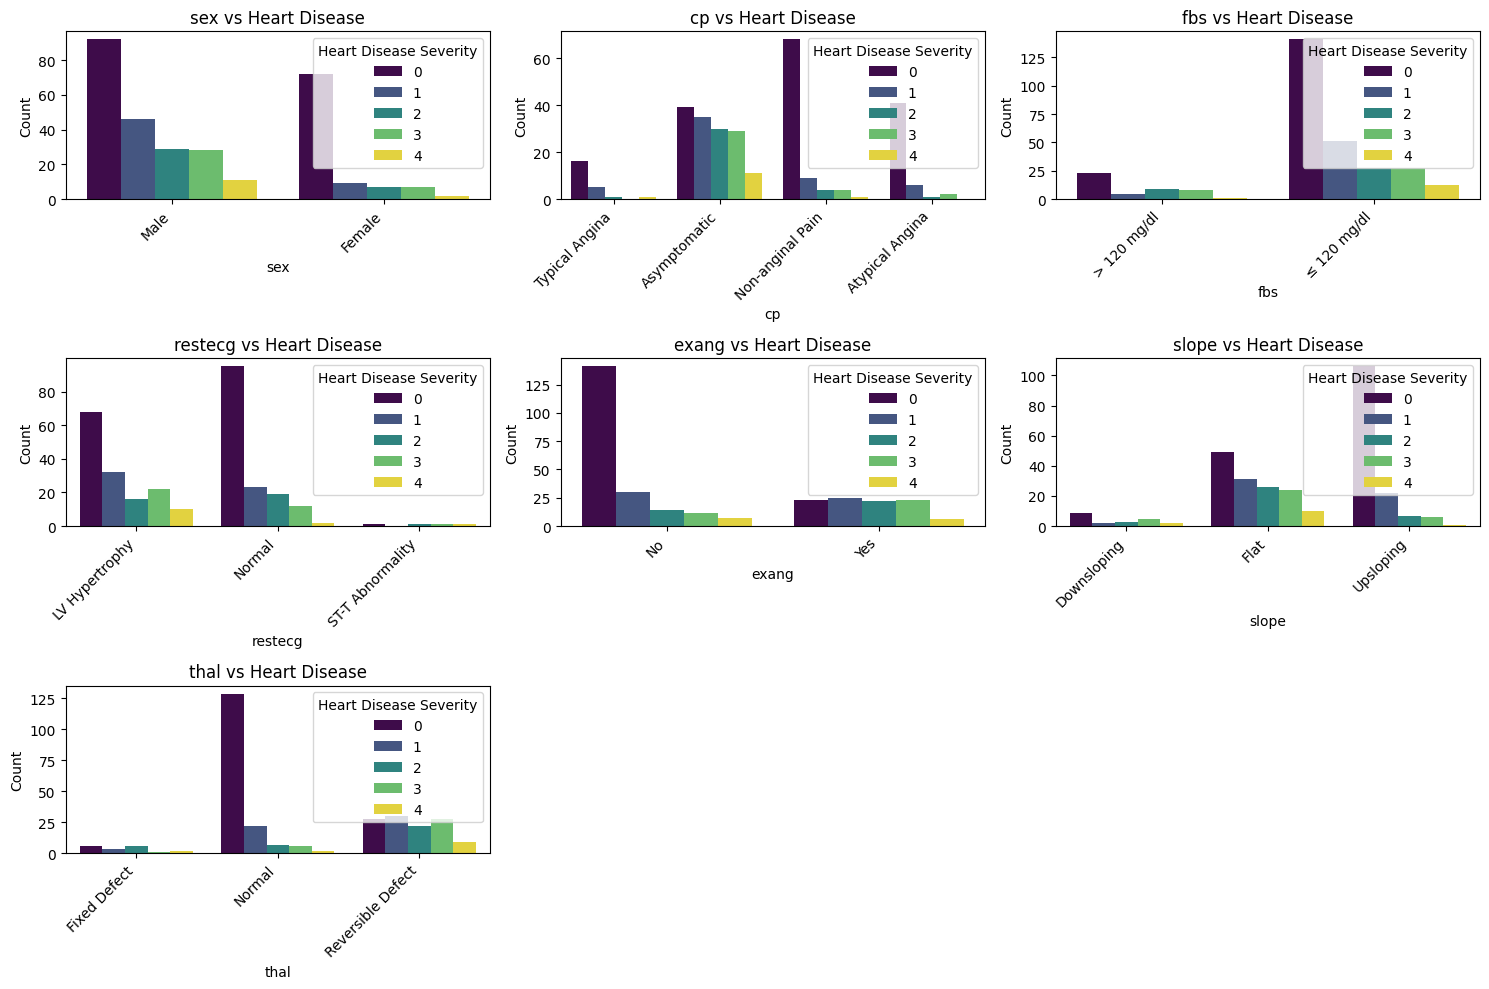

In [9]:
label_maps = {
    'sex': {0: 'Female', 1: 'Male'},
    'cp': {
        1: 'Typical Angina',
        2: 'Atypical Angina',
        3: 'Non-anginal Pain',
        4: 'Asymptomatic'
    },
    'fbs': {0: '≤ 120 mg/dl', 1: '> 120 mg/dl'},
    'restecg': {
        0: 'Normal',
        1: 'ST-T Abnormality',
        2: 'LV Hypertrophy'
    },
    'exang': {0: 'No', 1: 'Yes'},
    'slope': {
        1: 'Upsloping',
        2: 'Flat',
        3: 'Downsloping'
    },
    'thal': {
        3: 'Normal',
        6: 'Fixed Defect',
        7: 'Reversible Defect'
    }
}

# Initialize df_plot correctly using the 'original' DataFrame from heart_disease.data
df_plot = heart_disease.data.original.copy()

# Apply label mappings to the relevant categorical columns
for col, mapping in label_maps.items():
    if col in df_plot.columns: # Ensure the column exists in the DataFrame
        df_plot[col] = df_plot[col].map(mapping)

# Plotting all categorical features against 'num' (heart disease severity)
plt.figure(figsize=(15, 10)) # Adjust figure size for better display of multiple subplots
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1) # Create a 3x3 grid of subplots (7 categorical_cols will fit)
    sns.countplot(data=df_plot, x=col, hue='num', palette='viridis')
    plt.title(f'{col} vs Heart Disease')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.legend(title='Heart Disease Severity', loc='upper right') # Add legend title and position

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

FEATURE ENGINEERING

Numerical Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_engineer = Pipeline([
    ('scaler', StandardScaler())
])

Categorical Feature Encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

cat_engineer = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])

Apply Feature Engineering

In [12]:
feature_engineer = ColumnTransformer(
    transformers=[
        ('num_feat', num_engineer, numerical_cols),
        ('cat_feat', cat_engineer, categorical_cols)
    ]
)

In [13]:
X_final = feature_engineer.fit_transform(pd.DataFrame(
    X_clean,
    columns=numerical_cols + categorical_cols
))


MODEL DEVELOPMENT

Converting pandas dataframe into numpy arrays as required by upcoming stages

In [14]:
X_final_df = pd.DataFrame(
    X_final,
    columns=[f'feat_{i}' for i in range(X_final.shape[1])]
)


Logistic Regression Pipeline

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

logreg = LogisticRegression(max_iter=1000)

scores = cross_validate(
    logreg,
    X_final_df,
    y,
    cv=5,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr'],
    error_score='raise'
)

for metric in [
    'accuracy',
    'precision_weighted',
    'recall_weighted',
    'roc_auc_ovr'
]:
    values = scores[f'test_{metric}']
    print(f"{metric}: {values.mean():.3f} ± {values.std():.3f}")


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.587 ± 0.033
precision_weighted: 0.542 ± 0.046
recall_weighted: 0.587 ± 0.033
roc_auc_ovr: 0.798 ± 0.034


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313

Random Forest Pipeline

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

scores = cross_validate(
    rf,
    X_final_df,
    y,
    cv=5,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr'],
    error_score='raise'
)


for metric in [
    'accuracy',
    'precision_weighted',
    'recall_weighted',
    'roc_auc_ovr'
]:
    values = scores[f'test_{metric}']
    print(f"{metric}: {values.mean():.3f} ± {values.std():.3f}")


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santu\AppData\Local\Programs\Python\Pytho

accuracy: 0.584 ± 0.054
precision_weighted: 0.499 ± 0.069
recall_weighted: 0.584 ± 0.054
roc_auc_ovr: 0.791 ± 0.026


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


EXPERIMENT TRACKING

Installing MLFlow

In [17]:
# Install mlflow and reload the kernel if needed
import sys
!{sys.executable} -m pip install mlflow
import mlflow
import mlflow.sklearn


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
mlflow.set_experiment("Heart Disease Classification")
from sklearn.model_selection import cross_validate

def train_and_log_model(model, model_name, X, y):
    with mlflow.start_run(run_name=model_name):

        # Log model name
        mlflow.log_param("model", model_name)

        # Cross-validation
        scores = cross_validate(
            model,
            X,
            y,
            cv=5,
            scoring=[
                'accuracy',
                'precision_weighted',
                'recall_weighted',
                'roc_auc_ovr'
            ]
        )

        # Log metrics (mean values)
        mlflow.log_metric("accuracy", scores['test_accuracy'].mean())
        mlflow.log_metric("precision", scores['test_precision_weighted'].mean())
        mlflow.log_metric("recall", scores['test_recall_weighted'].mean())
        mlflow.log_metric("roc_auc", scores['test_roc_auc_ovr'].mean())

        # Log std as metrics too (optional but good practice)
        mlflow.log_metric("accuracy_std", scores['test_accuracy'].std())

        # Fit model on full data and log it
        model.fit(X, y)
        mlflow.sklearn.log_model(model, artifact_path="model")

        print(f"{model_name} logged successfully")


2026/01/06 14:25:30 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/06 14:25:30 INFO mlflow.store.db.utils: Updating database tables
2026/01/06 14:25:30 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/06 14:25:30 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/06 14:25:30 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/06 14:25:30 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/06 14:25:30 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/06 14:25:30 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/06 14:25:30 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/06 14:25:30 INFO alembic.runtime.migration: Running 

Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

train_and_log_model(
    logreg,
    "Logistic Regression",
    X_final_df,
    y
)


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1406: DataC

Logistic Regression logged successfully


Random Forests

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

train_and_log_model(
    rf,
    "Random Forest",
    X_final_df,
    y
)


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\santu\AppData\Local\Programs\Python\Pytho

Random Forest logged successfully


RF Confusion Matrix

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [22]:
with mlflow.start_run(run_name="RF_Confusion_Matrix"):
    rf.fit(X, y)
    y_pred = rf.predict(X)

    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Random Forest Confusion Matrix")

    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()


c:\Users\santu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
